In [6]:
import pandas as pd

# Replace the filename if different
df = pd.read_csv("quora_duplicate_questions.tsv", sep='\t')

# Remove missing rows
df.dropna(subset=["question1", "question2"], inplace=True)

df.head()


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0.0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0.0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0.0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0.0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0.0


In [7]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return " ".join([word for word in text.split() if word not in stop_words])

df["clean_q1"] = df["question1"].apply(clean_text)
df["clean_q2"] = df["question2"].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

all_questions = pd.concat([df["clean_q1"], df["clean_q2"]])
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_questions)

q1_vecs = tfidf_matrix[:len(df)]
q2_vecs = tfidf_matrix[len(df):]


In [9]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(q1_vecs, q2_vecs)
df["similarity_score"] = [similarities[i, i] for i in range(len(df))]


In [10]:
def find_similar_questions(query, top_n=5):
    query_clean = clean_text(query)
    query_vec = vectorizer.transform([query_clean])

    scores = cosine_similarity(query_vec, q1_vecs).flatten()
    top_indices = scores.argsort()[-top_n:][::-1]

    for i in top_indices:
        print(f"\n🔹 Similar Question: {df.iloc[i]['question1']}")
        print(f"✅ Score: {scores[i]:.4f}")
        print("–" * 60)

# Try it
find_similar_questions("How to learn Python?")



🔹 Similar Question: What can I do if I learn Python?
✅ Score: 1.0000
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

🔹 Similar Question: What are some of the best ways to learn python?
✅ Score: 0.7976
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

🔹 Similar Question: How easy is it to learn Python?
✅ Score: 0.7775
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

🔹 Similar Question: What's the best way to learn Python?
✅ Score: 0.7514
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

🔹 Similar Question: What's the best way to learn python on my own?
✅ Score: 0.7514
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––


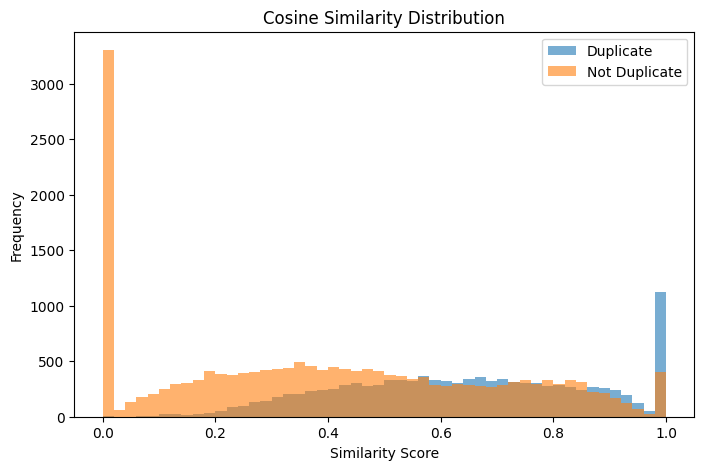

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df[df["is_duplicate"] == 1]["similarity_score"], bins=50, alpha=0.6, label='Duplicate')
plt.hist(df[df["is_duplicate"] == 0]["similarity_score"], bins=50, alpha=0.6, label='Not Duplicate')
plt.title("Cosine Similarity Distribution")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()
